Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**
- Get **ROC AUC** (Receiver Operating Characteristic, Area Under the Curve)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

## Import

In [ ]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', na_values=[0, -2.000000e-08], index_col='id')

In [ ]:
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,needs repair
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,NaN,Lake Nyasa,Mnyusi B,Iringa,11,5.0,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0
8776.0,NaN,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,NaN,Lake Victoria,Nyamara,Mara,20,2.0,Serengeti,Natta,280.0,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0
34310.0,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,NaN,Pangani,Majengo,Manyara,21,4.0,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,0
67743.0,NaN,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,NaN,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63.0,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1
19728.0,NaN,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,NaN,Lake Victoria,Kyanyamisa,Kagera,18,1.0,Karagwe,Nyakasimbi,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0


In [ ]:
train['status_group'].value_counts()

functional                 32259
non functional             22823
functional needs repair     4317
Name: status_group, dtype: int64

## EDA

- How can we transform our target so that this is a **binary classification** problem?

In [ ]:
train['needs_repair'] = train['status_group'].apply(lambda x: 0 if x == 'functional' else 1)
train['needs_repair'].value_counts()

0    32259
1    27140
Name: needs_repair, dtype: int64

Our new wrangle function

In [ ]:
def wrangle(X):
  # Make a copy
  X = X.copy()

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]

  X.drop(columns=high_card_cols, inplace=True)

  # Drop repeated columns
  cols = ['extraction_type_group', 'quantity']
  X.drop(columns=cols, inplace=True)

  # Create new, binary target

  return X

In [ ]:
train = wrangle(train)

In [ ]:
test = wrangle(test)

# II. Split Data

In [ ]:
# Split TV / FM
target = 'needs_repair'
y = train[target]
X = train.drop(columns=[target, 'status_group'])

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# Build Model



In [ ]:
model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      RandomForestClassifier(n_estimators=50,
                                             n_jobs = -1,
                                             random_state = 42,
                                            #  max_depth=6,
                                             ))
model.fit(X_train, y_train);

# Check Metrics

**Accuracy**

In [ ]:
print('Training Accuracy',model.score(X_train, y_train))
print('Validation Accuracy',model.score(X_val, y_val))

Training Accuracy 0.9995370272943455
Validation Accuracy 0.8223905723905723


**Confusion Matrix**

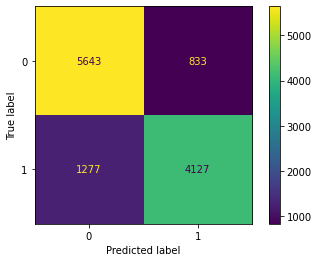

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model,
                      X_val,
                      y_val,
                      values_format = '.0f'
                      # display_labels=['no repair needed', 'needs repair'],
                      )

**Recall:** 
- Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [ ]:
print('Recall:', 4127 / (4127+1277))

Recall 0.7636935603256847


**Precision:** 
- Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [ ]:
print('Precision:', 4127 / (4127+833))

Precision: 0.8320564516129032


**Classification Report**

In [ ]:
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      6476
           1       0.83      0.76      0.80      5404

    accuracy                           0.82     11880
   macro avg       0.82      0.82      0.82     11880
weighted avg       0.82      0.82      0.82     11880



# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

Scenario 1: Choose pumps randomly

In [ ]:
n_inspections = 2000

In [ ]:
y_val.value_counts(normalize=True).min()

0.4548821548821549

Scenario 2: Using our model "out of the box"

In [ ]:
data = {'y_val': y_val,
        'y_pred': model.predict(X_val)}

results = pd.DataFrame(data)

mask = results['y_pred'] == 1
sample = results[mask].sample(n_inspections)

print(f'Inspections conducted: {n_inspections}')
print(f'Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample.y_val.sum())*100)

Inspections conducted: 2000
Pumps repaired: 1678
Funds wasted: 32200


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.9`) need repair.

In [ ]:
data = {'y_val': y_val,
        'y_pred_proba': model.predict_proba(X_val)[:,-1]}

results = pd.DataFrame(data)

threshold = 0.88

mask = results['y_pred_proba'] > threshold

sample = results[mask].sample(n_inspections)

print(f'Inspections conducted: {n_inspections}')
print(f'Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample.y_val.sum())*100)

Inspections conducted: 2000
Pumps repaired: 1955
Funds wasted: 4500


# Get ROC AUC (Receiver Operating Characteristic, Area Under the Curve)

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. **The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.**"

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures **how well a classifier ranks predicted probabilities.** So, when you get your classifier’s ROC AUC score, you need to **use predicted probabilities, not discrete predictions.**

ROC AUC ranges **from 0 to 1.** Higher is better. A naive majority class **baseline** will have an ROC AUC score of **0.5.** 

#### Scikit-Learn docs
- [User Guide: Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

#### More links
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

In [ ]:
# "The ROC curve is created by plotting the true positive rate (TPR) 
# against the false positive rate (FPR) 
# at various threshold settings."

# Use scikit-learn to calculate TPR & FPR at various thresholds
fpr, tpr, thresholds = roc_curve(results.y_val, results.y_pred_proba)

In [ ]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.000000
1,0.001390,0.130459,1.000000
2,0.002316,0.197261,0.980000
3,0.003552,0.250185,0.960000
4,0.004787,0.301999,0.940000
5,0.005405,0.345300,0.920000
6,0.007258,0.381569,0.900000
7,0.009419,0.414508,0.880000
8,0.009574,0.414508,0.873333
9,0.011427,0.444301,0.860000


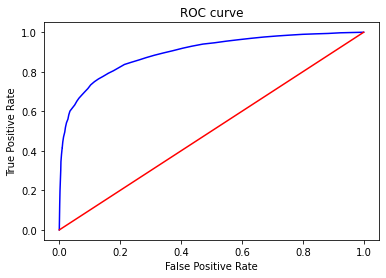

In [ ]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, color='blue')
plt.plot((0,1), (0,1), color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [ ]:
# Use scikit-learn to calculate the area under the curve.
roc_auc_score(results.y_val, results.y_pred_proba)

0.8961033570859368

**Recap:** ROC AUC measures how well a classifier ranks predicted probabilities. So, when you get your classifier’s ROC AUC score, you need to use predicted probabilities, not discrete predictions. 

Your code may look something like this:

```python
from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict_proba(X_test_transformed)[:, -1] # Probability for last class
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))
```

ROC AUC ranges from 0 to 1. Higher is better. A naive majority class baseline will have an ROC AUC score of 0.5.